# qsystem_2 Demonstrator



#### Stared with a copy of pulse-generator-with-envelope.ipyng

# Pulse Generator

***Collin Bradford***

Creates a series of pulses as defined by the user. User may control the pulse width, the delay between pulses, and the number of pulses. The decimated buffer is triggered and read out entirely to see the pulse waveform up to 1024 clock cycles. 

It should be noted that for some reason, the buffer returns with a delay of 200 samples before the data comes in. In order to see more, one can edit line 32 of the ASM program to read: `p.seti(0,1,3,200)` instead of `p.seti(0,1,3,0)` which will delay the readout such that it starts 200 samples later. This will effectively move the waveform earlier in the readout. However, the external trigger on the oscilloscope will trigger 200 samples after the waveform starts. 

The output and input channels can be changed using the variables defined below. To properly view the waveform from this notebook, a wire must be connected between the output channel and the input channel. 


Modified to use a gaussian envelope in I.  Two changes:
1.  In the asm program, use `outsel=00`
2.  In python, upload envelope with     `soc.gens[outputChannel-1].load(addr=0,xin_i=xg_i, xin_q=xg_q)`


In [1]:
import matplotlib.pyplot as plt

from pynq import Overlay
import numpy as np

from qsystem_2 import *
from qsystem2_asm import *

In [2]:
soc = PfbSoc('qsystem_2.bit', force_init_clks=False)

|  Address | Page,Register | Variable Name | Description |
| --- | --- | --- | --- |
| 1 | 0,1 | pulseCount | Number of pulses to generate|
| 2 | 0,2 | frequency | DDS Frequency |
| 3 | 0,3 | phase | phase |
| 4 | 0,4 | address | address of envelope |
| 5 | 0,5 | gain | Amplitude of output in ADUs. |
| 6 | 0,6 | nsamp | number of samples in one output pulse |
| 7 | 0,7 | nsync | number of samples between pulse beginnings |
| n/a | 0,8 | temp | used to calculate values to pack bits into nsamp |
| n/a | 0,9 | trig | the value 0xC001 that triggers the average block |

In [3]:
inputChannel  = 0 #0 or 1 
outputChannel = 7 #1-7 

In [4]:
with ASM_Program() as p:
    #Write all memory addresses to program memory
    p.memri(0,1,1,"Pulse Count")
    p.memri(0,2,2,"Encoded Frequency")
    p.memri(0,3,3,"Phase")
    p.memri(0,4,4,"Address")
    p.memri(0,5,5,"Gain")
    p.memri(0,6,6,"nsamp")
    p.memri(0,7,7,"nsync")
    #Set up nsamp and DAC selection register.
    # For DDS, set outsel=01    
    #p.regwi(0,8,0b1001,"0b1001, stdysel = 1 (zero value), mode = 0 (nsamp), outsel = 01 (dds).")
    # For envelope, set outsel=00
    p.regwi(0,8,0b1000,"0b1000, stdysel = 1 (zero value), mode = 0 (nsamp), outsel = 00 (envelope).")
    p.bitwi(0,8,8, "<<", 16)
    p.bitw(0,6,6,"|",8)
    #Delay the start a bit
    p.synci(1000)
    #Trigger value for the average block. 
    p.regwi(0,9,0xC001,"Trigger pmod0 bit0 and input channels 0 and 1") # Trigger average/buffer blocks of ADC channels 0 and 1
    #p.seti(0,0,9,200)  # Send the trigger bits to the input channel
    #p.seti(inputChannel,0,0,10) # Clear the readout bit after 10 clock ticks
    #Loop
    p.label("LOOP")
    p.set(outputChannel,0,2,3,4,5,6,0)
    p.sync(0,7)
    p.seti(inputChannel,0,9,0) # Send the trigger bits to the input channel
    p.seti(inputChannel,0,0,10) # Clear the readout bit after 10 clock ticks
    p.loopnz(0,1,"LOOP")
    #End the signal
    p.seti(0,0,0,0)
soc.tproc.load_asm_program(p)
#print(p)

In [5]:
def runner(pulseCount, frequency, gain, phase, address, nsamp, nsync, outputType):
    
    freqRegDAC = freq2reg(soc.fs_dac, frequency, B=32)
    soc.tproc.single_write(addr=1, data = pulseCount-1)
    soc.tproc.single_write(addr=2, data = freqRegDAC)
    soc.tproc.single_write(addr=3, data = phase)
    soc.tproc.single_write(addr=4, data = address)
    soc.tproc.single_write(addr=5, data = gain)
    soc.tproc.single_write(addr=6, data = nsamp)
    soc.tproc.single_write(addr=7, data = nsync)
    
    # For envelope, upload envelope
    xg_i = gauss(mu=16*nsamp/2, si=nsamp, length=16*nsamp, maxv=30000)
    xg_q = np.zeros(len(xg_i))
    soc.gens[outputChannel-1].load(addr=address, xin_i=xg_i, xin_q=xg_q)

    soc.readouts[inputChannel].set_out(outputType)
    soc.readouts[inputChannel].set_freq(frequency)
    decimatedLength = int(pulseCount*nsamp)
    soc.avg_bufs[inputChannel].config(address = 0, length=nsamp)
    soc.avg_bufs[inputChannel].enable()
    soc.tproc.stop()
    soc.tproc.start()
    idec,qdec = soc.get_decimated(ch=inputChannel, length = decimatedLength)
    iacc,qacc =  soc.get_accumulated(ch=inputChannel, length=pulseCount)
    return idec,qdec,iacc,qacc

pulseCount = 5 
frequency = 200
gain = 30000
phase = 0
address = 0
nsamp = 100
nsync = 210
outputType = "product"
idec,qdec,iacc,qacc = runner(pulseCount, frequency, gain, phase, address, nsamp, nsync, outputType)

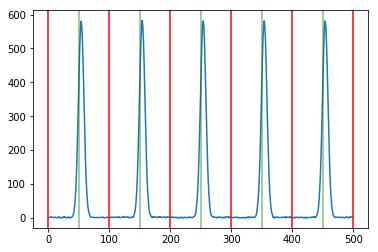

In [6]:
plt.plot(np.abs(idec + 1j*qdec))
for i in range(pulseCount+1):
    plt.axvline(i*nsamp, c='r')
    if i < pulseCount:
        plt.axvline((i+0.5)*nsamp, c='g', alpha=0.5)

Text(0.5,0,'Pulse Number')

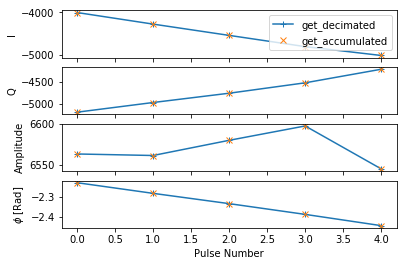

In [7]:
iaccSums = idec.reshape(-1, nsamp).sum(axis=1)
qaccSums = qdec.reshape(-1, nsamp).sum(axis=1)
fig,ax = plt.subplots(4,1,sharex=True)
ax[0].plot(iaccSums, "-+", label="get_decimated")
ax[0].plot(iacc, "x", label="get_accumulated")
ax[0].set_ylabel("I")
ax[0].legend()

ax[1].plot(qaccSums, "-+")
ax[1].plot(qacc, "x")
ax[1].set_ylabel("Q")

ax[2].plot(np.abs(iaccSums + 1j*qaccSums), "-+")
ax[2].plot(np.abs(iacc + 1j*qacc), "x")
ax[2].set_ylabel("Amplitude")

ax[3].plot(np.arctan2(qaccSums, iaccSums), "-+")
ax[3].plot(np.arctan2(qacc, iacc), "x")
ax[3].set_ylabel("$\phi$ [Rad]")

ax[3].set_xlabel("Pulse Number")

In [8]:
# Make sure it works a second time.
idec,qdec,iacc,qacc = runner(pulseCount, frequency, gain, phase, address, nsamp, nsync, outputType)
print("iacc =",iacc)

iacc = [6423 6490 6533 6549 6563]
